# Eager execution
## Setup and basic usage

In [1]:
import os
import tensorflow as tf
import cProfile

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
tf.executing_eagerly()

True

In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print(f"hello, {m}")

hello, [[4.]]


In [4]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [5]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [7]:
# Use NumPy values
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [8]:
# Obtain numpy value from a tensor
print(a.numpy())

[[1 2]
 [3 4]]


## Dynamic control flow

In [9]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1

In [10]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


## Eager training
### Computing gradients

In [11]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w

grad = tape.gradient(loss, w)
print(grad)     # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


### Train a model

In [2]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis]/255, tf.float32),
    tf.cast(mnist_labels, tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [3]:
# Build the model
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3, 3], activation='relu',
                            input_shape=(None, None, 1)),
    tf.keras.layers.Conv2D(16, [3, 3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

In [4]:
for images, labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.01018761  0.01772876  0.0213014   0.00684064 -0.03205892 -0.05122165
  -0.00835354  0.00340477 -0.02160832 -0.01486837]]


In [5]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [6]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        
        # Add asserts to check the shape of the output.
        tf.debugging.assert_equal(logits.shape, (32, 10))
        
        loss_value = loss_object(labels, logits)
    
    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [7]:
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print ('Epoch {} finished'.format(epoch))

In [8]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

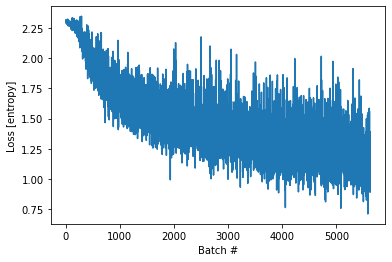

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### Variables and optimizers

In [11]:
class Linear(tf.keras.Model):
    def __init__(self):
        super(Linear, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B

In [12]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

In [13]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model,
                training_inputs, training_outputs)))

Initial loss: 68.411
Loss at step 000: 65.767
Loss at step 020: 30.105
Loss at step 040: 14.086
Loss at step 060: 6.888
Loss at step 080: 3.653
Loss at step 100: 2.198
Loss at step 120: 1.543
Loss at step 140: 1.248
Loss at step 160: 1.115
Loss at step 180: 1.056
Loss at step 200: 1.029
Loss at step 220: 1.017
Loss at step 240: 1.011
Loss at step 260: 1.009
Loss at step 280: 1.008


In [14]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 1.007


In [15]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 3.0190913677215576, B = 2.0101470947265625


### Object-based saving

In [16]:
model.save_weights('weights')
status = model.load_weights('weights')

In [17]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [18]:
x.assign(2.)    # Assign a new value to the variables and save.
checkpoint_path = './ckpt'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [19]:
x.assign(11.)   # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)    # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = './path_to_model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Object-oriented metrics

In [21]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

### Summaries and TensorBoard

In [22]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():  # or call writer.set_as_default() before the loop.
    for i in range(steps):
        step = i + 1
        # Calculate loss with your real train function.
        loss = 1 - 0.001 * step
        if step % 100 == 0:
            tf.summary.scalar('loss', loss, step=step)

In [25]:
!dir tb

 Volume in drive D is Backup
 Volume Serial Number is 96A1-99BD

 Directory of d:\Documents\DeepLearning\TensorFlow_Guide\TensorFlow_2\tb

2021/03/19  15:58    <DIR>          .
2021/03/19  15:58    <DIR>          ..
2021/03/19  15:58               669 events.out.tfevents.1616140733.JAYTHINKPADX1.13784.636520.v2
               1 File(s)            669 bytes
               2 Dir(s)  332,176,822,272 bytes free


## Advanced automatic differentiation topics
### Dynamic models

In [26]:
def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
        # Variables are automatically tracked.
        # But to calculate a gradient from a tensor, you must `watch` it.
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad * grad)
    init_value = value
    while value > init_value - rate * grad_norm:
        x = init_x - rate * grad
        value = fn(x)
        rate /= 2.0
    return x, value

### Custom gradients

In [27]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y, grad_fn

In [28]:
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

In [29]:
# The gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [30]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(tf.constant(100.)).numpy()

nan

In [31]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

In [32]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(tf.constant(0.)).numpy()

0.5

In [33]:
# And the gradient computation also works at x = 100.
grad_log1pexp(tf.constant(100.)).numpy()

1.0

## Performance

In [34]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time it's used, exclude from timing.
    tf.matmul(x, x)
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
    # tf.matmul can return before completing the matrix multiplication
    # (e.g., can return after enqueing the operation on a CUDA stream).
    # The x.numpy() call below will ensure that all enqueued operations
    # have completed (and will also copy the result to host memory,
    # so we're including a little more than just the matmul operation
    # time).
    _ = x.numpy()
    end = time.time()
    return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
    print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.list_physical_devices("GPU"):
    with tf.device("/gpu:0"):
        print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
    print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 1.2730257511138916 secs
GPU: 0.33003854751586914 secs


In [35]:
if tf.config.list_physical_devices("GPU"):
    x = tf.random.normal([10, 10])

    x_gpu0 = x.gpu()
    x_cpu = x.cpu()

    _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
    _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.identity instead.
